In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animal-image-dataset-90-different-animals


In [ ]:
# Importing necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

In [ ]:
# Ensuring the GPU is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('GPU is being used.')
else:
    print('GPU is not being used.')

GPU is being used.


In [ ]:
# Path to the dataset
dataset_path = "/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"

# List all the classes (Animal Types)
classes = os.listdir(dataset_path)
num_classes = len(classes)

# Display the number of classes along with names
print(f'Number of Classes: {num_classes}')
print(f'Classes: {classes}')

Number of Classes: 90
Classes: ['beetle', 'parrot', 'fox', 'wolf', 'hedgehog', 'turtle', 'snake', 'shark', 'horse', 'antelope', 'hamster', 'woodpecker', 'eagle', 'chimpanzee', 'bison', 'penguin', 'butterfly', 'sandpiper', 'hornbill', 'lion', 'lobster', 'oyster', 'otter', 'grasshopper', 'raccoon', 'dog', 'pigeon', 'donkey', 'hippopotamus', 'hummingbird', 'bear', 'coyote', 'bee', 'pig', 'rat', 'owl', 'caterpillar', 'koala', 'squid', 'hare', 'whale', 'mouse', 'tiger', 'fly', 'lizard', 'orangutan', 'bat', 'porcupine', 'kangaroo', 'gorilla', 'starfish', 'mosquito', 'crow', 'possum', 'goldfish', 'swan', 'elephant', 'sheep', 'dragonfly', 'zebra', 'seal', 'octopus', 'cow', 'ox', 'wombat', 'reindeer', 'panda', 'duck', 'goose', 'goat', 'badger', 'flamingo', 'crab', 'seahorse', 'rhinoceros', 'dolphin', 'okapi', 'moth', 'sparrow', 'pelecaniformes', 'squirrel', 'leopard', 'jellyfish', 'ladybugs', 'cockroach', 'hyena', 'cat', 'deer', 'turkey', 'boar']


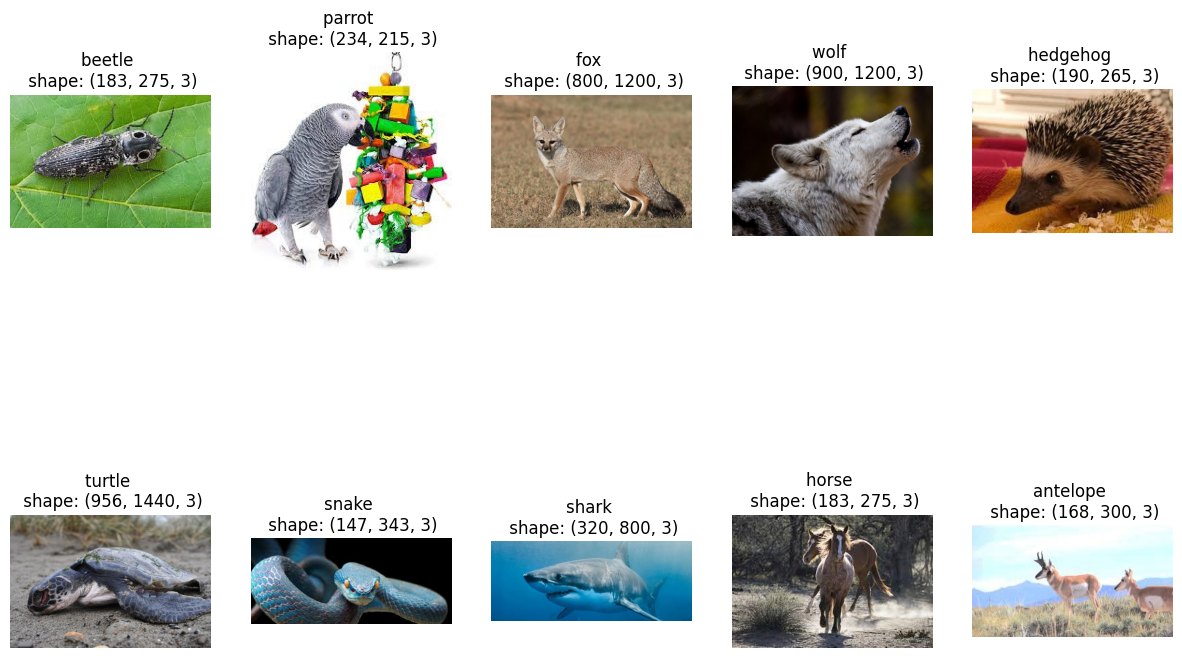

In [ ]:
# Visualize some sample images form the dataset
plt.figure(figsize=(15,10))
for i, class_name in enumerate(classes[:10]):
  class_path = os.path.join(dataset_path, class_name)
  img_name = os.listdir(class_path)[0]
  img_path = os.path.join(class_path, img_name)
  img = plt.imread(img_path)

  plt.subplot(2, 5, i+1)
  plt.imshow(img)
  plt.title(f'{class_name} \n shape: {img.shape}')
  plt.axis('off')
plt.show()

In [ ]:
# Preprocessing the data.
# Define image size and batch_size - Trained model - MobileNetV2 - 224 x 224
img_size = (224, 224)
batch_size = 64 # There can be 64 images in a batch

# Data Augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

# Create training and validation generators
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 4860 images belonging to 90 classes.
Found 540 images belonging to 90 classes.


In [ ]:
# Map the classes - class_indices
class_indices = train_generator.class_indices
print(class_indices)
# Extract class names
class_names = list(class_indices.keys())
print("Class Names:", class_names)

{'antelope': 0, 'badger': 1, 'bat': 2, 'bear': 3, 'bee': 4, 'beetle': 5, 'bison': 6, 'boar': 7, 'butterfly': 8, 'cat': 9, 'caterpillar': 10, 'chimpanzee': 11, 'cockroach': 12, 'cow': 13, 'coyote': 14, 'crab': 15, 'crow': 16, 'deer': 17, 'dog': 18, 'dolphin': 19, 'donkey': 20, 'dragonfly': 21, 'duck': 22, 'eagle': 23, 'elephant': 24, 'flamingo': 25, 'fly': 26, 'fox': 27, 'goat': 28, 'goldfish': 29, 'goose': 30, 'gorilla': 31, 'grasshopper': 32, 'hamster': 33, 'hare': 34, 'hedgehog': 35, 'hippopotamus': 36, 'hornbill': 37, 'horse': 38, 'hummingbird': 39, 'hyena': 40, 'jellyfish': 41, 'kangaroo': 42, 'koala': 43, 'ladybugs': 44, 'leopard': 45, 'lion': 46, 'lizard': 47, 'lobster': 48, 'mosquito': 49, 'moth': 50, 'mouse': 51, 'octopus': 52, 'okapi': 53, 'orangutan': 54, 'otter': 55, 'owl': 56, 'ox': 57, 'oyster': 58, 'panda': 59, 'parrot': 60, 'pelecaniformes': 61, 'penguin': 62, 'pig': 63, 'pigeon': 64, 'porcupine': 65, 'possum': 66, 'raccoon': 67, 'rat': 68, 'reindeer': 69, 'rhinoceros': 

In [ ]:
# Load MobileNetV2 as the base model
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the base model weights, training
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x) # output layer

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
# Model summary
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,661,978 (13.97 MB)

 Trainable params: 1,403,994 (5.36 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs = 20
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 82s 909ms/step - accuracy: 0.0524 - loss: 4.5034 - val_accuracy: 0.5859 - val_loss: 3.1385
Epoch 2/20
 1/75 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.2812 - loss: 3.4784

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.2812 - loss: 3.4784 - val_accuracy: 0.5859 - val_loss: 3.1094
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.4288 - loss: 2.9273 - val_accuracy: 0.7461 - val_loss: 1.7835
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.5312 - loss: 2.2833 - val_accuracy: 0.7441 - val_loss: 1.7817
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.6542 - loss: 1.7044 - val_accuracy: 0.8184 - val_loss: 1.1377
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.7188 - loss: 1.2239 - val_accuracy: 0.8125 - val_loss: 1.1513
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 95s 560ms/step - accuracy: 0.7502 - loss: 1.1318 - val_accuracy: 0.8184 - val_loss: 0.9235
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.7344 - loss: 1.1935 - val_accuracy: 0.8164 - val_loss: 0.9240
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 547ms/step - accuracy: 0.7929 - loss: 0.8770 - val_accuracy: 0.8262 - val_loss:

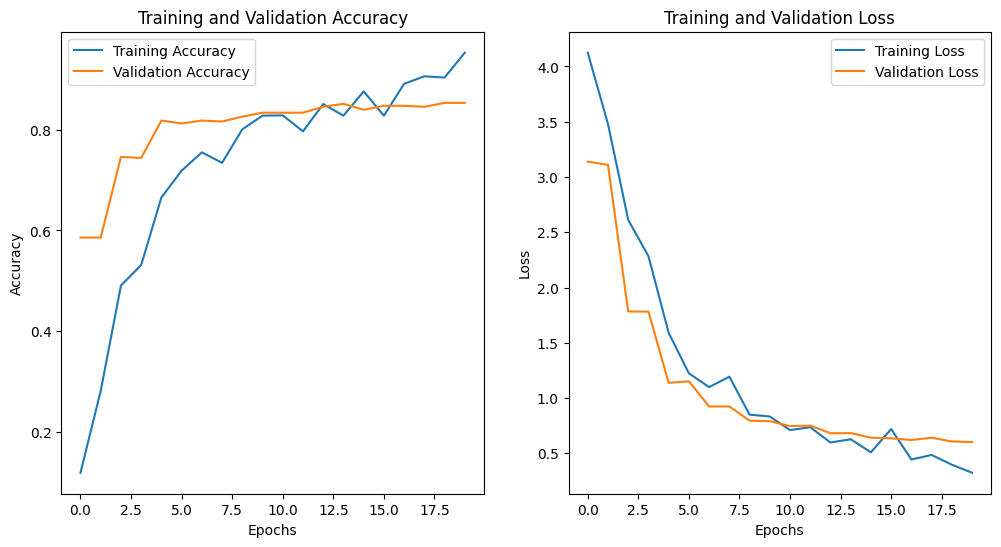

In [ ]:
# Evaluate the model - plotting the training and validation acc/loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 986ms/step - accuracy: 0.8673 - loss: 0.5598
Validation Loss: 0.6051286458969116
Validation Accuracy: 0.855555534362793


In [ ]:
# Save the model
model.save('MCAR.keras')

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

model = load_model('MCAR.keras')

def predict_animal(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]

    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

In [ ]:
os.listdir('/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/parrot')

['5affc48d37.jpg',
 '4aba5914cd.jpg',
 '3ac69be3f6.jpg',
 '29c26708a0.jpg',
 '96c5e35a54.jpg',
 '60e0c50a4a.jpg',
 '27a9ce4e1a.jpg',
 '64bd254fef.jpg',
 '46ed4828b1.jpg',
 '3a0c5d4582.jpg',
 '6a0ab0de34.jpg',
 '84b6622dbc.jpg',
 '6be2eb3fb3.jpg',
 '1bcd666a4e.jpg',
 '87bc6bdcd7.jpg',
 '1b9f359f9c.jpg',
 '62fc818264.jpg',
 '7a7fdb0450.jpg',
 '9d0d266d23.jpg',
 '8f5a2730b3.jpg',
 '4c26cd72e2.jpg',
 '4faf55514e.jpg',
 '2f207b75e3.jpg',
 '56b19e9dbc.jpg',
 '1dd93e1004.jpg',
 '66e79b1a2f.jpg',
 '34f9668c8e.jpg',
 '3de507dbb6.jpg',
 '0b29c10342.jpg',
 '64c08f053c.jpg',
 '060cca8826.jpg',
 '036b760476.jpg',
 '46c1b71d00.jpg',
 '8cdc657d99.jpg',
 '61def3553e.jpg',
 '0100ec7408.jpg',
 '8a8a69d934.jpg',
 '7d5cb5f5fa.jpg',
 '47ef39ceb6.jpg',
 '7dab3a1142.jpg',
 '46de4406fb.jpg',
 '6a184a05f3.jpg',
 '89d679b9e5.jpg',
 '0f072e6ce1.jpg',
 '0d778c6833.jpg',
 '0b2a1e349a.jpg',
 '3f5e9e225b.jpg',
 '4af25ae32d.jpg',
 '1cabf8a760.jpg',
 '5b1030ddd5.jpg',
 '91f0604cc7.jpg',
 '080a286cf3.jpg',
 '50e40b5356

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


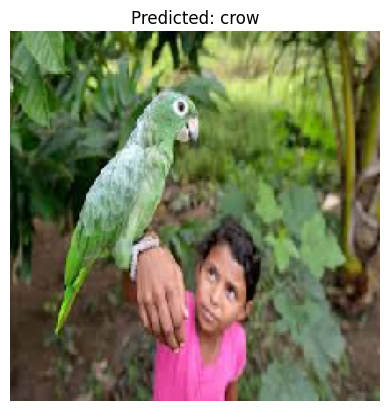

In [ ]:
predict_animal('/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/parrot/0100ec7408.jpg')

Path to dataset files: /kaggle/input/animal-image-dataset-90-different-animals
GPU is being used with memory growth enabled.
Number of Classes: 90
Classes: ['beetle', 'parrot', 'fox', 'wolf', 'hedgehog', 'turtle', 'snake', 'shark', 'horse', 'antelope', 'hamster', 'woodpecker', 'eagle', 'chimpanzee', 'bison', 'penguin', 'butterfly', 'sandpiper', 'hornbill', 'lion', 'lobster', 'oyster', 'otter', 'grasshopper', 'raccoon', 'dog', 'pigeon', 'donkey', 'hippopotamus', 'hummingbird', 'bear', 'coyote', 'bee', 'pig', 'rat', 'owl', 'caterpillar', 'koala', 'squid', 'hare', 'whale', 'mouse', 'tiger', 'fly', 'lizard', 'orangutan', 'bat', 'porcupine', 'kangaroo', 'gorilla', 'starfish', 'mosquito', 'crow', 'possum', 'goldfish', 'swan', 'elephant', 'sheep', 'dragonfly', 'zebra', 'seal', 'octopus', 'cow', 'ox', 'wombat', 'reindeer', 'panda', 'duck', 'goose', 'goat', 'badger', 'flamingo', 'crab', 'seahorse', 'rhinoceros', 'dolphin', 'okapi', 'moth', 'sparrow', 'pelecaniformes', 'squirrel', 'leopard', 'je

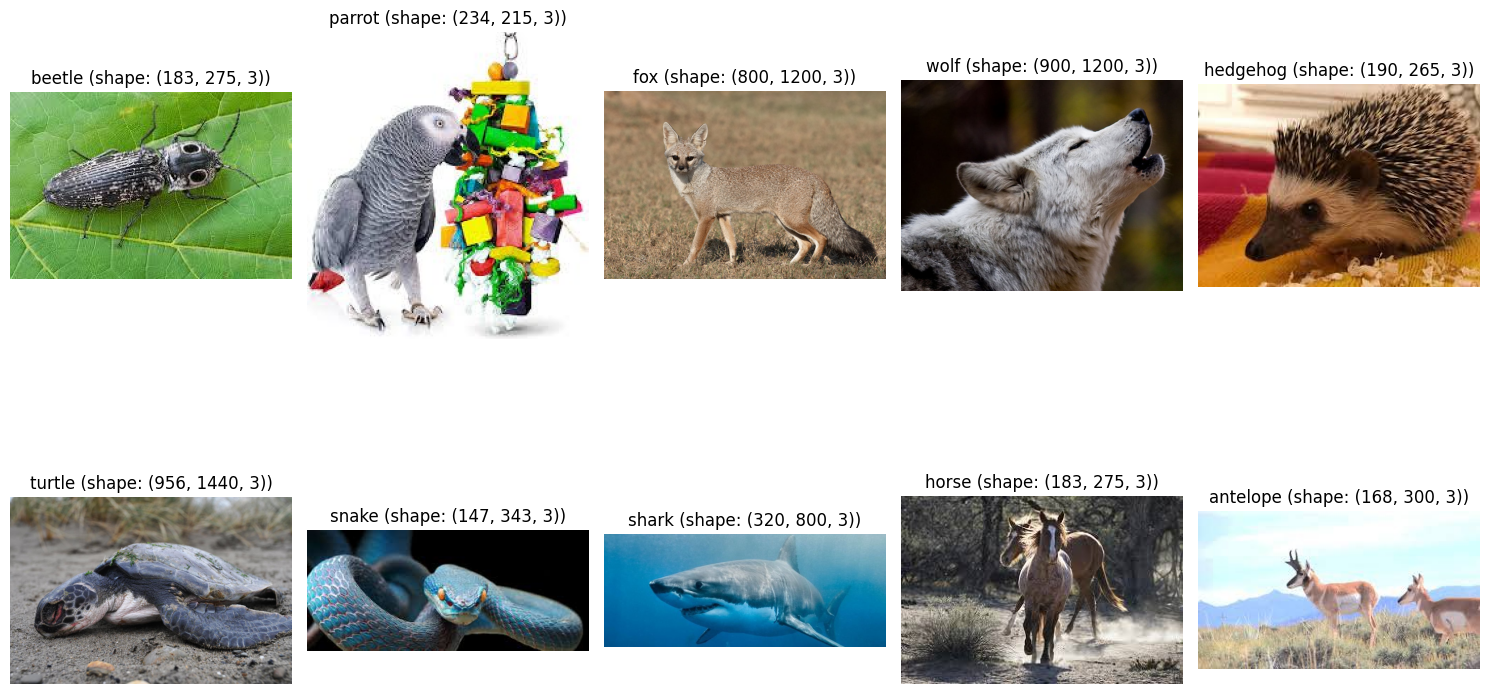

Found 4860 images belonging to 90 classes.
Found 540 images belonging to 90 classes.
Class Indices: {'antelope': 0, 'badger': 1, 'bat': 2, 'bear': 3, 'bee': 4, 'beetle': 5, 'bison': 6, 'boar': 7, 'butterfly': 8, 'cat': 9, 'caterpillar': 10, 'chimpanzee': 11, 'cockroach': 12, 'cow': 13, 'coyote': 14, 'crab': 15, 'crow': 16, 'deer': 17, 'dog': 18, 'dolphin': 19, 'donkey': 20, 'dragonfly': 21, 'duck': 22, 'eagle': 23, 'elephant': 24, 'flamingo': 25, 'fly': 26, 'fox': 27, 'goat': 28, 'goldfish': 29, 'goose': 30, 'gorilla': 31, 'grasshopper': 32, 'hamster': 33, 'hare': 34, 'hedgehog': 35, 'hippopotamus': 36, 'hornbill': 37, 'horse': 38, 'hummingbird': 39, 'hyena': 40, 'jellyfish': 41, 'kangaroo': 42, 'koala': 43, 'ladybugs': 44, 'leopard': 45, 'lion': 46, 'lizard': 47, 'lobster': 48, 'mosquito': 49, 'moth': 50, 'mouse': 51, 'octopus': 52, 'okapi': 53, 'orangutan': 54, 'otter': 55, 'owl': 56, 'ox': 57, 'oyster': 58, 'panda': 59, 'parrot': 60, 'pelecaniformes': 61, 'penguin': 62, 'pig': 63, '

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,661,978 (13.97 MB)

 Trainable params: 1,403,994 (5.36 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 51s 571ms/step - accuracy: 0.0484 - loss: 4.5095 - val_accuracy: 0.5078 - val_loss: 3.2316
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.2969 - loss: 3.3785 - val_accuracy: 0.5254 - val_loss: 3.2101
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 70s 499ms/step - accuracy: 0.4136 - loss: 2.9727 - val_accuracy: 0.7246 - val_loss: 1.8805
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.6094 - loss: 1.9347 - val_accuracy: 0.7207 - val_loss: 1.8680
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 475ms/step - accuracy: 0.6432 - loss: 1.7912 - val_accuracy: 0.7949 - val_loss: 1.1988
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.5625 - loss: 1.5866 - val_accuracy: 0.7930 - val_loss: 1.1882
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 552ms/step - accuracy: 0.7381 - loss: 1.1782 - val_accuracy: 0.8223 - val_loss: 0.9441
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.8281 - loss: 0.9236 - val_accuracy: 0.

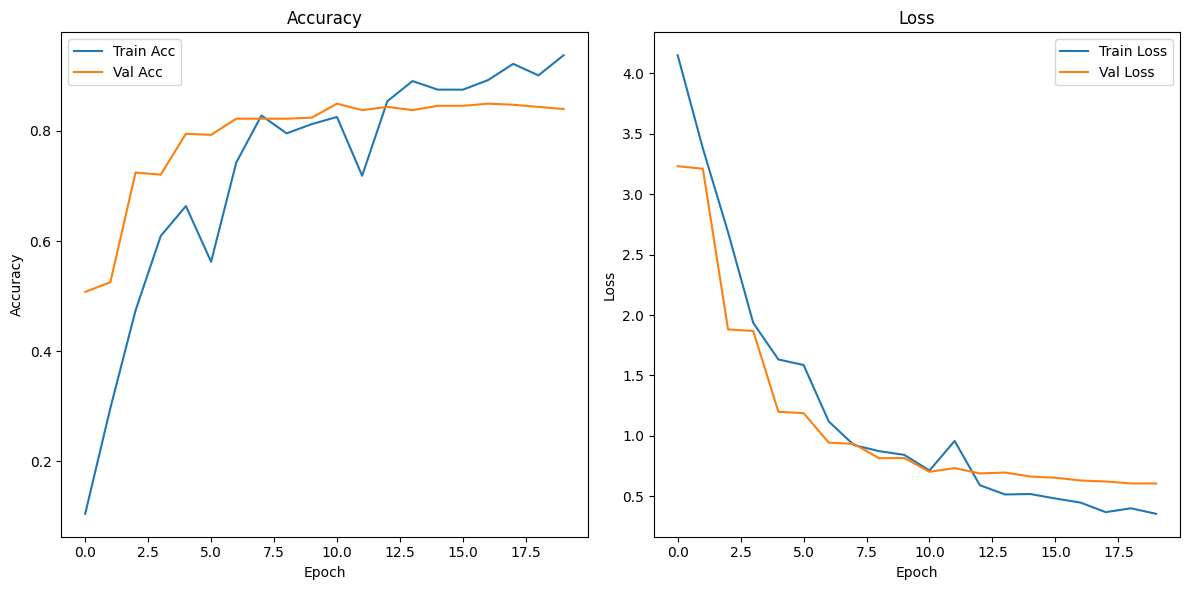

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 794ms/step - accuracy: 0.8574 - loss: 0.5527
Validation Loss: 0.6052892804145813
Validation Accuracy: 0.8425925970077515
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 742ms/step
Classification Report:
                precision    recall  f1-score   support

      antelope       0.00      0.00      0.00         6
        badger       0.00      0.00      0.00         6
           bat       0.00      0.00      0.00         6
          bear       0.00      0.00      0.00         6
           bee       0.00      0.00      0.00         6
        beetle       0.00      0.00      0.00         6
         bison       0.00      0.00      0.00         6
          boar       0.00      0.00      0.00         6
     butterfly       0.00      0.00      0.00         6
           cat       0.00      0.00      0.00         6
   caterpillar       0.00      0.00      0.00         6
    chimpanzee       0.00      0.00      0.00         6
     cockroach       0.00      0.00      0.00         6
   

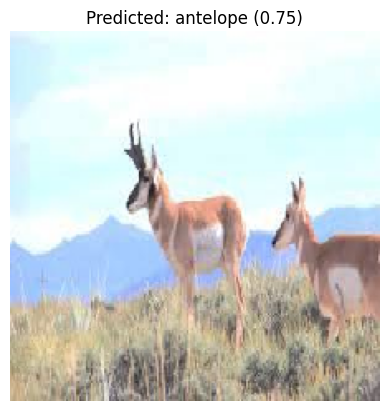

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
import kagglehub

try:
    from sklearn.metrics import classification_report
    SKLEARN_AVAILABLE = True
except ImportError:
    SKLEARN_AVAILABLE = False
    print("scikit-learn not installed. Classification report will be skipped. To enable, install scikit-learn via `pip install scikit-learn`.")


def download_dataset(dataset_ref: str) -> str:
    """
    Download the latest version of a Kaggle dataset using kagglehub.
    Returns the local path to the dataset.
    """
    path = kagglehub.dataset_download(dataset_ref)
    print(f"Path to dataset files: {path}")
    return path


def configure_gpu_growth():
    """
    Enable memory growth for the first GPU if available.
    """
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print('GPU is being used with memory growth enabled.')
    else:
        print('GPU is not being used.')


def visualize_samples(dataset_path: str, classes: list, num_samples: int = 10):
    """
    Display a grid of sample images from the dataset.
    """
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(classes[:num_samples]):
        class_dir = os.path.join(dataset_path, class_name)
        img_name = os.listdir(class_dir)[0]
        img_path = os.path.join(class_dir, img_name)
        img = plt.imread(img_path)

        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f'{class_name} (shape: {img.shape})')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


def build_data_generators(dataset_path: str, img_size: tuple, batch_size: int):
    """
    Create training and validation ImageDataGenerators.
    """
    datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.1)

    train_gen = datagen.flow_from_directory(
        dataset_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    val_gen = datagen.flow_from_directory(
        dataset_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    return train_gen, val_gen


def build_model(num_classes: int, input_shape: tuple):
    """
    Construct a MobileNetV2-based model with custom top layers.
    """
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = False

    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


def plot_history(history):
    """
    Plot training & validation accuracy and loss.
    """
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


def predict_and_report(model_path: str, class_names: list, img_path: str):
    """
    Load a saved model, predict on a single image, and display the result.
    """
    model = load_model(model_path)

    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    pred_idx = np.argmax(preds)
    pred_class = class_names[pred_idx]

    plt.imshow(img)
    plt.title(f"Predicted: {pred_class} ({preds[0][pred_idx]:.2f})")
    plt.axis('off')
    plt.show()


def main():
    # Step 1: Download and prepare data
    dataset_path = download_dataset("iamsouravbanerjee/animal-image-dataset-90-different-animals")
    data_dir = os.path.join(dataset_path, "animals/animals")

    # Step 2: GPU config
    configure_gpu_growth()

    # Step 3: List classes
    classes = os.listdir(data_dir)
    num_classes = len(classes)
    print(f"Number of Classes: {num_classes}")
    print(f"Classes: {classes}")

    # Step 4: Visualize samples
    visualize_samples(data_dir, classes)

    # Step 5: Build data generators
    img_size = (224, 224)
    batch_size = 64
    train_gen, val_gen = build_data_generators(data_dir, img_size, batch_size)
    print(f"Class Indices: {train_gen.class_indices}")
    class_names = list(train_gen.class_indices.keys())

    # Step 6: Build and summarize model
    model = build_model(num_classes, input_shape=(224, 224, 3))
    model.summary()

    # Step 7: Train
    history = model.fit(
        train_gen,
        steps_per_epoch=train_gen.samples // batch_size,
        validation_data=val_gen,
        validation_steps=val_gen.samples // batch_size,
        epochs=20
    )

    # Step 8: Plot training history
    plot_history(history)

    # Step 9: Evaluate and report
    val_loss, val_acc = model.evaluate(val_gen)
    print(f"Validation Loss: {val_loss}")
    print(f"Validation Accuracy: {val_acc}")

    # Optionally: classification report on a batch
    if SKLEARN_AVAILABLE:
        y_true = val_gen.classes
        y_pred = model.predict(val_gen).argmax(axis=1)
        print("Classification Report:")
        print(classification_report(y_true, y_pred, target_names=class_names))
    else:
        print("Skipping classification report; scikit-learn not available.")

    # Step 10: Save model
    model.save('MCAR.keras')

    # Step 11: Single-image prediction demo
    demo_img = os.path.join(data_dir, class_names[0], os.listdir(os.path.join(data_dir, class_names[0]))[0])
    predict_and_report('MCAR.keras', class_names, demo_img)


if __name__ == "__main__":
    main()


In [1]:
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.4 MB/s eta 0:00:00


GPU configured for memory growth.
Found 4860 images belonging to 90 classes.
Found 540 images belonging to 90 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 51s 561ms/step - accuracy: 0.0493 - loss: 4.5119 - val_accuracy: 0.5000 - val_loss: 3.2114
Epoch 2/20
 1/75 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.2969 - loss: 3.4075

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.2969 - loss: 3.4075 - val_accuracy: 0.5117 - val_loss: 3.1932
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 553ms/step - accuracy: 0.4239 - loss: 2.9383 - val_accuracy: 0.7344 - val_loss: 1.8040
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.5781 - loss: 2.0391 - val_accuracy: 0.7520 - val_loss: 1.7705
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 558ms/step - accuracy: 0.6669 - loss: 1.7126 - val_accuracy: 0.7969 - val_loss: 1.1626
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.7188 - loss: 1.2615 - val_accuracy: 0.8027 - val_loss: 1.1442
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 546ms/step - accuracy: 0.7461 - loss: 1.1481 - val_accuracy: 0.8340 - val_loss: 0.9025
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.6875 - loss: 1.2417 - val_accuracy: 0.8301 - val_loss: 0.9040
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 541ms/step - accuracy: 0.7915 - loss: 0.8746 - val_accuracy: 0.8398 - val_

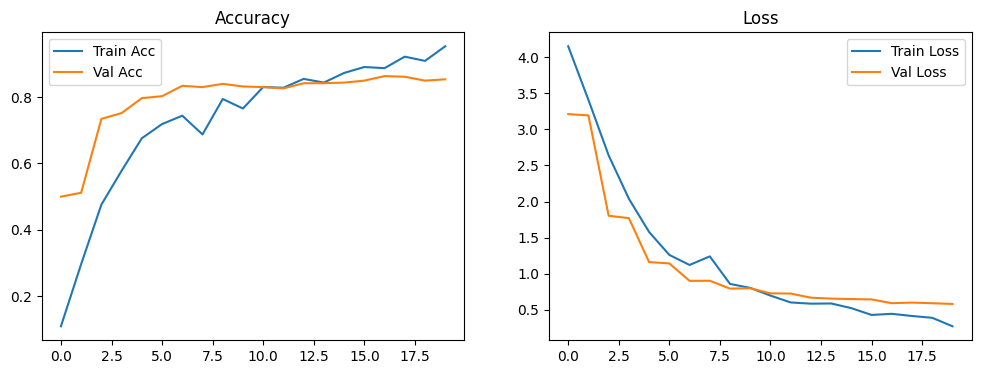

    epoch  train_accuracy  val_accuracy  train_loss  val_loss
0       1        0.109466      0.500000    4.150434  3.211374
1       2        0.296875      0.511719    3.407508  3.193168
2       3        0.476022      0.734375    2.639427  1.803971
3       4        0.578125      0.751953    2.039132  1.770472
4       5        0.675980      0.796875    1.578899  1.162562
5       6        0.718750      0.802734    1.261550  1.144240
6       7        0.743953      0.833984    1.122622  0.902509
7       8        0.687500      0.830078    1.241719  0.904032
8       9        0.794204      0.839844    0.860291  0.795074
9      10        0.765625      0.832031    0.805161  0.799989
10     11        0.830484      0.830078    0.698525  0.729689
11     12        0.828125      0.826172    0.603937  0.726760
12     13        0.854879      0.841797    0.586742  0.669514
13     14        0.843750      0.841797    0.589660  0.656935
14     15        0.872811      0.843750    0.524559  0.650578
15     1

FileUpload(value={}, accept='image/*', description='Upload')

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted: shark with confidence 0.83
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted: seal with confidence 0.98
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted: lion with confidence 0.85
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted: orangutan with confidence 0.99


In [5]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
import kagglehub
from PIL import Image
import ipywidgets as widgets
from IPython.display import display
from io import BytesIO

# Attempt to import classification_report
try:
    from sklearn.metrics import classification_report
    SKLEARN_AVAILABLE = True
except ImportError:
    SKLEARN_AVAILABLE = False
    print("scikit-learn not installed. Classification report will be skipped. To enable, install scikit-learn via `pip install scikit-learn`.")

# --- Helper functions ---
def download_dataset(dataset_ref: str) -> str:
    path = kagglehub.dataset_download(dataset_ref)
    return path

def configure_gpu_growth():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        return True
    return False

def build_data_generators(dataset_path: str, img_size: tuple, batch_size: int):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)
    train_gen = datagen.flow_from_directory(
        dataset_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )
    val_gen = datagen.flow_from_directory(
        dataset_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )
    return train_gen, val_gen

def build_model(num_classes: int, input_shape: tuple):
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = False
    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base.input, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def train_model(data_dir, img_size, batch_size, epochs):
    train_gen, val_gen = build_data_generators(data_dir, img_size, batch_size)
    class_names = list(train_gen.class_indices.keys())
    model = build_model(len(class_names), input_shape=(img_size[0], img_size[1], 3))
    history = model.fit(
        train_gen,
        steps_per_epoch=train_gen.samples // batch_size,
        validation_data=val_gen,
        validation_steps=val_gen.samples // batch_size,
        epochs=epochs
    )
    model.save('MCAR.keras')
    # save class names
    with open('class_names.txt', 'w') as f:
        f.write("\n".join(class_names))

    # Convert history to DataFrame
    hist_df = pd.DataFrame({
        'epoch': list(range(1, len(history.history['accuracy']) + 1)),
        'train_accuracy': history.history['accuracy'],
        'val_accuracy': history.history['val_accuracy'],
        'train_loss': history.history['loss'],
        'val_loss': history.history['val_loss'],
    })
    return history, class_names, hist_df

def predict_image(model_path: str, class_names: list, img) -> tuple:
    model = load_model(model_path)
    img = img.resize((224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    preds = model.predict(img_array)
    idx = np.argmax(preds)
    return class_names[idx], preds[0][idx]

# --- Main Execution ---
# Download dataset
dataset_path = download_dataset("iamsouravbanerjee/animal-image-dataset-90-different-animals")
data_dir = os.path.join(dataset_path, 'animals/animals')

# Configure GPU
enable_gpu = True  # Set to True if you want to enable GPU memory growth
if enable_gpu:
    if configure_gpu_growth():
        print("GPU configured for memory growth.")
    else:
        print("No GPU detected; running on CPU.")

# Set parameters for training
epochs = 20
img_size = (224, 224)
batch_size = 64

# Train the model
history, class_names, hist_df = train_model(data_dir, img_size, batch_size, epochs)

# Plot training history
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(history.history['accuracy'], label='Train Acc')
ax[0].plot(history.history['val_accuracy'], label='Val Acc')
ax[0].set_title('Accuracy')
ax[1].plot(history.history['loss'], label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Val Loss')
ax[1].set_title('Loss')
for a in ax:
    a.legend()
plt.show()

# Display training history DataFrame
print(hist_df)

# Image upload widget
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)
display(upload_widget)

# Function to handle image prediction

def handle_upload(change):
    if upload_widget.value:
        uploaded_file = next(iter(upload_widget.value.values()))
        img = Image.open(BytesIO(uploaded_file['content']))
        pred_class, confidence = predict_image('MCAR.keras', class_names, img)
        print(f"Predicted: {pred_class} with confidence {confidence:.2f}")

# Link the upload widget to the prediction function
upload_widget.observe(handle_upload, names='value')